In [22]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json 
import pickle

# Scraper

Scrape pcs.com for different years.

- first get race names into list 
- then for each race get the years

In [28]:
PCS_URL = 'https://www.procyclingstats.com/'
RACES_URL = PCS_URL + 'races.php'
START_YEAR = 2000
END_YEAR = 2024
TOPN = 200 #topn to get 
REDO = False

data_filename = f'WT_races_top{TOPN}_{START_YEAR}-{END_YEAR}.json'

In [29]:
#first get the desired races names (only multiple stage races in 201 for reference) into a list

try:
    url = RACES_URL + "?year=2019&circuit=1&class=2.UWT&filter=Filter"

    page = requests.get(url)

    soup = BeautifulSoup(page.content, "html.parser")
    li = soup.find("li", class_="more4")
    races = []
    for span in soup.find_all("span", class_='flag'):
        race = span.parent.find("a", href=True)['href'].split('/')[1]
        races.append(race)
    
#     races.remove('tour-of-guangxi')
#     races.remove('tour-of-turkey')
#     races.remove('renewi-tour')
    # races.append('la-route-d-occitanie')
except Exception as e:
    print(e)
    print("ERROR")
    print("COULD NOT SCRAPE RACES")
    print("SETTING TO DEFAULT")
    print("WARNING Might not be updated ok. for example renewi-tour/binckback-tour etc")
    races = ['tour-down-under', 'uae-tour', 'paris-nice', 'tirreno-adriatico', 'volta-a-catalunya', 'itzulia-basque-country', 'tour-de-romandie',
             'giro-d-italia', 'tour-of-california', 'dauphine', 'tour-de-suisse', 'tour-de-france', 'tour-de-pologne', 'benelux-tour', 'vuelta-a-espana']
    print()
print("Use these races:")
print(races)

Use these races:
['tour-down-under', 'uae-tour', 'paris-nice', 'tirreno-adriatico', 'volta-a-catalunya', 'itzulia-basque-country', 'tour-of-turkey', 'tour-de-romandie', 'giro-d-italia', 'tour-of-california', 'dauphine', 'tour-de-suisse', 'tour-de-france', 'tour-de-pologne', 'renewi-tour', 'vuelta-a-espana', 'tour-of-guangxi']


In [30]:
def get_race_topn(race, year, topn=TOPN):
    "Use BS to scrape pcs.com and get the topn for a race in a year"
    page = requests.get(PCS_URL+"race/"+race+"/"+str(year)+"/gc/") #only get GC
    race_soup = BeautifulSoup(page.content, "html.parser")
    i = 0
    top_l = []
    try:
        for entry in race_soup.find("th", class_="time_wonlost").find_next().find_all("a", href=True):
            if i >= topn:
                break
    #         print(entry['href'])
            if entry['href'][:5] == 'rider':
                top_l.append(entry.text)
                i += 1
    except AttributeError:
        return topn*[np.nan]
    return top_l

In [31]:
# For every race and year and put into a dictionary


if REDO:
    d = {}
    for year in range(START_YEAR, END_YEAR):
        print(year)
        d[year] = {}
        for race in races:
            print(race, end=' ')
            d[year][race] = get_race_topn(race, year, TOPN)

        print()

In [32]:
# Save data to json for later
import json
import os

#set to True if reload data from pcs.com

if not os.path.exists(data_filename) and REDO:
    with open(data_filename, "w") as write_file:
        json.dump(d, write_file, indent=4)
    print(f"Wrote data to {data_filename}")

In [33]:
#Load old data

with open(data_filename, "r") as infile:
    d = json.load(infile)
    d = {int(key): item for key,item in d.items()}
print(f"Loaded {data_filename} into d")

Loaded WT_races_top200_2000-2024.json into d


In [34]:
#Make pandas dataframe for each year

from collections import defaultdict

def check_names_len_append(names, topn):
    """
    if names is less than the topn you want
    apped with np.nan
    if it is larger just take the topn
    """
    n = len(names)
    if n < topn:
        for _ in range(topn - n):
            names.append(np.nan)
    elif n > topn:
        names = names[:topn]
    return names

def make_df_year(year, prev_years=2):
    """
    for each year make a dataframe with all names and their results in the races chosen above in 'races'
    with the results of this year, previosu year
    and two years ago
    
    THIS IS SO SLOW
    """

    dfs = []

    if prev_years < 1:
        raise ValueError(f"prev_years should be >= 1, is now {prev_years}")

    for prev_year in range(0, prev_years+1):
#         print(f"Getting {year-prev_year}")
        for key, item in d[year-prev_year].items():
            d[year-prev_year][key] = check_names_len_append(item, TOPN)
            
        df_year = pd.DataFrame(d[year-prev_year])
        if prev_year > 0:
            df_year = df_year.add_suffix(f'_prev{prev_year}')
        dfs.append(df_year)

    df_ = pd.concat(dfs)
    
    #ONly unique names
    series = pd.Series(np.ravel(df_.to_numpy())).unique()
    codes, uniques = pd.factorize(series)
    df = pd.concat(dfs, axis=1, ignore_index=False)
    
    
# #     #the slow part starts here
# #     print('here slowness')
    dd = defaultdict(list)
    for name in uniques:
        dd['name'].append(name)
        for race in df_.columns: 
            try:
                idx = df.index[df[race] == name][0] + 1
#                 idx = int(df[race].loc[df[race] == name].index[0]+1)
            except:
                idx = np.nan
            dd[race].append(idx)
        dd['year'].append(year)
#     print(".")
    df = pd.DataFrame(dd)
    df = df.reset_index()
    df = df.set_index('name') 
    print("...done")
    return df

In [36]:
if REDO:

    dfs = []

    PREV_YEARS = 3

    for year in range(START_YEAR+PREV_YEARS, END_YEAR):
        print(year)
        df = make_df_year(year, PREV_YEARS)
        df['top10'] = df['tour-de-france'].apply(lambda x: 1 if x <= 10 else 0)
        df['top5'] = df['tour-de-france'].apply(lambda x: 1 if x <= 5 else 0)
        df['top3'] = df['tour-de-france'].apply(lambda x: 1 if x <= 3 else 0)
        df['top1'] = df['tour-de-france'].apply(lambda x: 1 if x == 1 else 0)
        dfs.append(df)

    df = pd.concat(dfs)

    df.to_pickle('df_data.pl')
    test_mask = df['year'].isin(np.random.choice(range(START_YEAR+PREV_YEARS, END_YEAR-2), 4, replace=False))
    df_test = df.loc[test_mask]
    df_train = df.loc[~test_mask]
    df_train.to_pickle('train.pl')
    df_test.to_pickle('test.pl')

In [37]:
df_train = pd.read_pickle('train.pl')
df_test = pd.read_pickle('test.pl')

In [38]:
#only take those that actually did the TDF
df_train = df_train.loc[~df_train['tour-de-france'].isna()]
df_test = df_test.loc[~df_test['tour-de-france'].isna()]

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import HistGradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import resample
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, roc_curve, precision_score
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.metrics import plot_confusion_matrix
# from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import GridSearchCV
import pickle

top1


/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/sklearn/met

all
0.5 0.7483525535420099
ppv 0.5
HistGradientBoostingClassifier(max_bins=100, max_depth=2, max_leaf_nodes=4,
                               min_samples_leaf=5)
top3


/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


all
1.0 0.6666666666666666
ppv 1.0
HistGradientBoostingClassifier(max_bins=100, max_depth=2, max_leaf_nodes=3,
                               min_samples_leaf=5)
top5


/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


all
0.5 0.5966159052453469
ppv 0.5
HistGradientBoostingClassifier(max_bins=100, max_depth=3, max_leaf_nodes=4,
                               min_samples_leaf=5)
top10


/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


all
0.6111111111111112 0.6313704028021017
ppv 0.6111111111111112
HistGradientBoostingClassifier(max_bins=100, max_depth=2, max_leaf_nodes=4,
                               min_samples_leaf=5)


/home/mart/anaconda3/envs/pcs/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


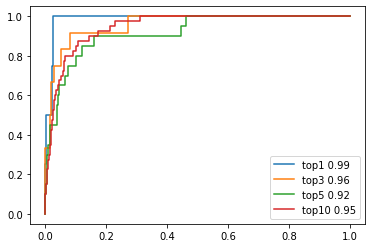

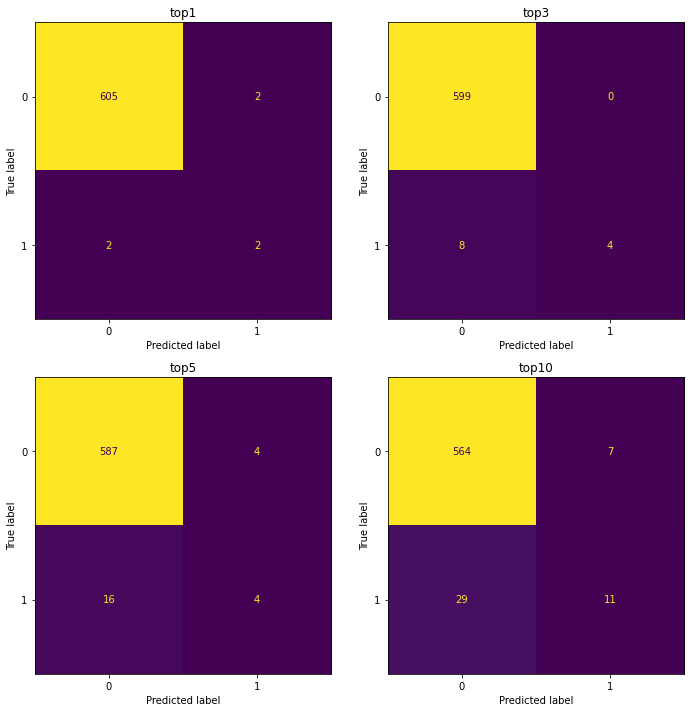

In [40]:
f, ax = plt.subplots(1)
drops = ['index', 'tour-de-france', 'year', 'top10', 'top5', 'top3', 'top1']
X_train = df_train.drop(drops, axis=1)#.fillna(1000)
X_test = df_test.drop(drops, axis=1)#.fillna(1000)
# X_train[X_train > 30] = 30
# X_test[X_test > 30] = 30
# X_max = np.max(X_train, axis=0)
# X_min = np.min(X_train, axis=0)
# X_train = (X_train - X_max)/np.maximum(1, (X_max - X_min))
# X_test = (X_test - X_max)/np.maximum(1, (X_max - X_min))
clfs = {}

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()
df_test_copy = df_test.copy(deep=True)
for label, ax_ in zip(['top1', 'top3', 'top5', 'top10'], axes):
    print(label)
    y_train = df_train[label]
    y_test = df_test[label]
    X_resampled, y_resampled = X_train, y_train #SMOTE().fit_resample(X_train, y_train)
    param_grid = {'max_depth': [2, 3], 'max_leaf_nodes': [3, 4], 'min_samples_leaf': [5], 'max_bins': [100]}
    base_est = HistGradientBoostingClassifier()
    clf = GridSearchCV(base_est, param_grid, scoring='precision', n_jobs=2)
    clf.fit(X_resampled, y_resampled)
    clfs[label] = clf
    n = len(y_test)
    y_pred = clf.predict(X_test)
    print('all')
    y_pred = clf.predict(X_test)

    print(clf.score(X_test, y_test), balanced_accuracy_score(y_test, y_pred))
    print("ppv", precision_score(y_test, y_pred))
    plot_confusion_matrix(clf, X_test, y_test, ax=ax_, colorbar=False)

    df_test_copy[label+"_pred"] = y_pred
    prob_y_pred = clf.predict_proba(X_test)
    df_test_copy[label+"prob"] = prob_y_pred[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, prob_y_pred[:, 1])
    ax.plot(fpr, tpr, label=label+f" {roc_auc_score(y_test, prob_y_pred[:, 1]):.2f}")
    ax_.set_title(label)
    print(clf.best_estimator_)
    with open(label+"clf.pl", 'wb') as outfile:
        pickle.dump(clf.best_estimator_, outfile)


fig.tight_layout()
ax.legend()

In [42]:
year = np.random.choice(df_test_copy['year'].unique())
print(year)

2021


In [43]:
df_test_copy.query(f'year == {year}').sort_values('top10prob', ascending=False)[['top10prob', 'top5prob', 'top3prob', 'top1prob', 'tour-de-france']].iloc[:20]

,top10prob,top5prob,top3prob,top1prob,tour-de-france
name,,,,,
MAS Enric,0.876686,0.703636,0.039887,0.001243,6.0
VALVERDE Alejandro,0.819061,0.442303,0.040030,0.000324,24.0
PORTE Richie,0.814293,0.314094,0.200122,0.004345,38.0
POGAČAR Tadej,0.796940,0.566997,0.574976,0.001877,1.0
KELDERMAN Wilco,0.755475,0.355171,0.141700,0.021376,5.0
THOMAS Geraint,0.595877,0.846092,0.183626,0.999906,41.0
QUINTANA Nairo,0.477501,0.098068,0.030501,0.000024,28.0
GAUDU David,0.430958,0.169184,0.014616,0.000966,11.0
MARTIN Guillaume,0.367003,0.077309,0.058580,0.000035,8.0


In [44]:
df_test_copy.query(f'year == {year}').sort_values('tour-de-france')[['year', 'top10_pred', 'top10prob']].iloc[:20]

,year,top10_pred,top10prob
name,,,
POGAČAR Tadej,2021,1,0.796940
VINGEGAARD Jonas,2021,0,0.029092
CARAPAZ Richard,2021,0,0.335779
O'CONNOR Ben,2021,0,0.158601
KELDERMAN Wilco,2021,1,0.755475
MAS Enric,2021,1,0.876686
LUTSENKO Alexey,2021,0,0.165289
MARTIN Guillaume,2021,0,0.367003
BILBAO Pello,2021,0,0.143266


In [45]:
df_ = make_df_year(2023, PREV_YEARS)

...done


In [46]:
drops = ['index', 'tour-de-france', 'year']
X = df_.drop(drops, axis=1)

In [47]:
X

,tour-down-under,uae-tour,paris-nice,tirreno-adriatico,volta-a-catalunya,itzulia-basque-country,tour-of-turkey,tour-de-romandie,giro-d-italia,tour-of-california,...,tour-de-romandie_prev3,giro-d-italia_prev3,tour-of-california_prev3,dauphine_prev3,tour-de-suisse_prev3,tour-de-france_prev3,tour-de-pologne_prev3,renewi-tour_prev3,vuelta-a-espana_prev3,tour-of-guangxi_prev3
name,,,,,,,,,,,,,,,,,,,,,
VINE Jay,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EVENEPOEL Remco,NaN,1.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
POGAČAR Tadej,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,1.0,NaN,NaN,NaN,NaN
ROGLIČ Primož,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1.0,NaN
VINGEGAARD Jonas,NaN,NaN,3.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,46.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MATHIS Marco,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,130.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DELAGE Mickaël,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,142.0,NaN
MORIN Emmanuel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,134.0,NaN


In [48]:
import pickle
for label in ["top1", "top3", "top5", "top10"]:
    with open(label+"clf.pl", 'rb') as infile:
        clf = pickle.load(infile)
    
    df_[label+"_pred"] = clf.predict(X)
    prob_y_pred = clf.predict_proba(X)
    df_[label+"prob"] = prob_y_pred[:, 1]


In [49]:
df_['prob'] = df_['top10prob']*df_['top5prob']*df_['top3prob']*df_['top1prob']

In [55]:
df_.loc[df_.index.str.contains('POG')][['prob', 'top10prob', 'top5prob', 'top3prob', 'top1prob', 'tour-de-france_prev1']]

,prob,top10prob,top5prob,top3prob,top1prob,tour-de-france_prev1
name,,,,,,
POGAČAR Tadej,0.084124,0.705245,0.979019,0.979664,0.124368,2.0


In [75]:
df_.sort_values('top10prob', ascending=False)[['prob', 'top10prob', 'top5prob', 'top3prob', 'top1prob']].iloc[:20]

,prob,top10prob,top5prob,top3prob,top1prob
name,,,,,
YATES Adam,2.795614e-05,0.955357,0.779559,0.051786,0.000725
VINGEGAARD Jonas,7.936596e-02,0.860538,0.453732,0.750113,0.270980
EVENEPOEL Remco,3.769127e-06,0.730814,0.034928,0.155332,0.000951
POGAČAR Tadej,8.412360e-02,0.705245,0.979019,0.979664,0.124368
MAS Enric,4.492945e-04,0.659334,0.764048,0.267815,0.003330
GAUDU David,4.275109e-04,0.609309,0.344761,0.027031,0.075288
LANDA Mikel,6.196971e-06,0.467821,0.243448,0.288299,0.000189
URÁN Rigoberto,4.612123e-08,0.450465,0.244932,0.032323,0.000013
HINDLEY Jai,1.484313e-04,0.440930,0.132253,0.195800,0.013000


In [ ]:
df_.query('name == "QUINTANA Nairo"')

In [65]:
df_ = df_year.join(df_prev, rsuffix='_prev').join(df_prev2, rsuffix="_prev2")
nraces = len(races)
data = {}
all_races = df_.columns
for name in uniques:
    average = 0
    n = 0
    d_ = {}
    for race in df_.columns:
        d_[]
        try:
            idx = df_[race].loc[df_[race] == name].index[0]+1
            if name == tdf_1:
                print(race, idx)
            n += 1
        except:
            idx = 0
        average += idx

    if n > 1:
        data[name+"_ave"] = average/n
        
data = dict(sorted(data.items(), key=lambda item: item[1]))

SyntaxError: invalid syntax (1349661443.py, line 10)

In [64]:
plt.figure(figsize=(25, 5))

x = list(data.keys())
y = np.array(list(data.values()))

plt.bar(range(len(x)), y, align='center')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][1:]
colors.append('k')

for i, (name, color) in enumerate(zip(tdf[:10], colors)):
    try:
        ix = x.index(name)
        plt.bar(ix, y[ix], color=color)
        plt.annotate(xy=(ix, y[ix]), text=f"tdf #{i+1}", textcoords='offset pixels', xytext=(-2, 10), rotation=90)
    except ValueError:
        print(f"{name} was #{i+1} in the tdf without any top20 results in the last 2 year")
        pass

plt.xticks(range(len(x)), x);

plt.xticks(rotation=90);
plt.xlim([-0.5, np.argmax(y[y<10])+0.5])
plt.ylim([0, 11])

NameError: name 'data' is not defined

<Figure size 1800x360 with 0 Axes>